In [19]:
%pip install pandas
%pip install seaborn
%pip install nltk
%pip install scikit-learn
%pip install wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
# Getting the dataset
fields=['target','ids','date','query','user','text']
df = pd.read_csv("Sentiment140.csv", encoding="ISO-8859-1", names=fields)
pd.options.display.max_colwidth = 280
# Removing unnecessary columns
df = df[['target', 'text']]

Negative    800000
Positive    800000
Name: target, dtype: int64


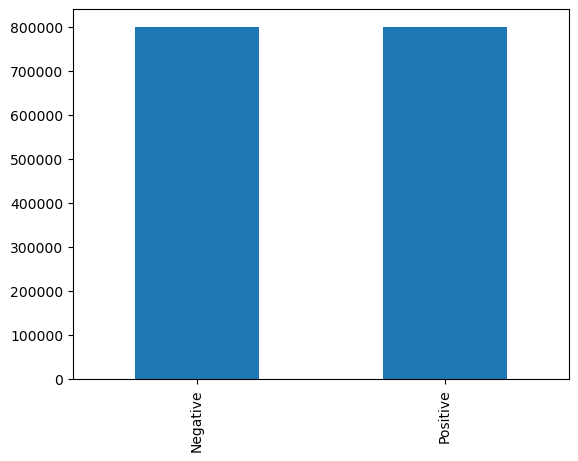

In [21]:
# Visualize the data sentiment distribution
sentiments = {0: "Negative", 4: "Positive"}
print(df.target.apply(lambda x: sentiments[x]).value_counts())
df.target.apply(lambda x: sentiments[x]).value_counts().plot(kind = 'bar')
plt.show()

In [22]:
def preprocess_text(text):
    # Clean the text data: 
    # remove usernames, urls, hashtags, numbers, and dates
    # downcast to lowercase

    # patterns
    url = r'https?:\/\/[\w\-\.]+\.[a-zA-Z]{2,}\/?\S*'
    username = r'@\w+'
    hashtag = r'#\w+'
    dates = r'\d{4}-\d{2}-\d{2}'

    #removing
    text = re.sub(url, '', text)
    text = re.sub(username, '', text)
    text = re.sub(hashtag, '', text)
    text = re.sub(dates, '', text)
    text = re.sub(r'\d+', '', text)

    # lowercase text
    #df['text'] = df['text'].astype('category')
    text = text.lower()
    
    # Remove stopwords
    stop_words = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further','he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    text = " ".join(words)
    
     
    
#     #remove stopwords again b/c some had punctuation next to chars(...)
#     new_stopwords = ['im', 'cant']
#     stpwrd = nltk.corpus.stopwords.words('english')
#     stpwrd.extend(new_stopwords)
#     words = [word for word in words if word.lower() not in stop_words]
#     text = " ".join(words)
    
    # Remove punctuation
    punct = r'[^\w\s]+'
    text = re.sub(punct, '', text)
    
    
    return text

In [23]:
df['text'] = df['text'].apply(preprocess_text)
#replacing blank cells with NaN
df['text'].replace('', np.nan, inplace=True)
#removing rows with no text
df.dropna(subset = ['text'], inplace = True)
df.head(10)

,target,text
0,0,awww thats bummer shoulda got david carr third day do it d
1,0,upset cant update facebook texting it might cry result school today also blah
2,0,dived many times ball managed save rest go bounds
3,0,whole body feels itchy like fire
4,0,no its not behaving all im mad here cant see over there
5,0,not whole crew
6,0,need hug
7,0,hey long time no see yes rains bit only bit lol im fine thanks hows
8,0,nope didnt have
9,0,que muera


In [24]:
# Splitting the data. 90% training data, 10% test data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],
                                                    test_size = 0.1, random_state = 0)

X_test


1262332                                                                      tweeting new phone cool
621375     woah eyeshield ending ive read first volumes so left go xd but still feels like big thing
488972                   damn right vella needs abusehe always abuses mecome think it u do quite lot
781605                                                                  miss amazing boobs used have
295774                                                           cant iras magically roll themselves
                                                     ...                                            
401207                                                 alkaline trio playing today amp not going see
1155374                                                                                  sounds good
760907                                                  mom asking could work wher friso im not sure
272559                                                                            today rai

In [25]:
# Vectorize the data. 
# Vectorization -> process of transforming text data into a numerical representation that can be used by models
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [26]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Support Vector Machines (SVM):
Time Taken: 15415 seconds
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     79444
           4       0.80      0.81      0.80     80101

    accuracy                           0.80    159545
   macro avg       0.80      0.80      0.80    159545
weighted avg       0.80      0.80      0.80    159545



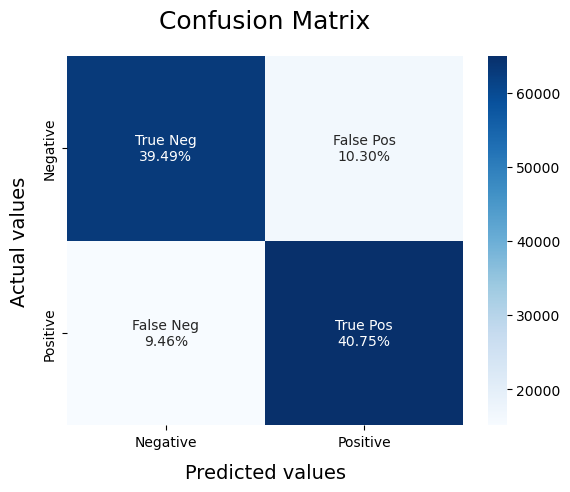

In [31]:
print("Support Vector Machines (SVM):")
import time
t2 = time.time()
svm_classifier = LinearSVC(max_iter=1000)
svm_classifier.fit(X_train, y_train)
print(f'Time Taken: {round(time.time()-t)} seconds')
model_Evaluate(svm_classifier)